In [1]:
!pip -q install torch_geometric

import torch
import numpy as np
import scipy.sparse as sp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.4 MB/s eta 0:00:00


# **Data Pre-processing**


*   Construct Graph data
*   Graph data pre-processing


In [2]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from google.colab import files

### Step 0. Load .csv file and dataframe

print('Step 0. Load dataframe')
uploaded = files.upload() # Eng_maplestory_for_GNN.csv
print()

data_frame = pd.read_csv('Eng_maplestory_for_GNN.csv')
print(data_frame)
print()
print('=======================================================')
print()

Step 0. Load dataframe


Saving Eng_maplestory_for_GNN.csv to Eng_maplestory_for_GNN.csv

          Character Main-Stat Sub-Stat                  Hometown Job Field  \
0              Hero       STR      DEX              Maple island   Warrior   
1           Paladin       STR      DEX              Maple island   Warrior   
2       Dark Knight       STR      DEX              Maple island   Warrior   
3      Dawn Warrior       STR      DEX                      Erev   Warrior   
4            Mihile       STR      DEX                      Erev   Warrior   
5           Blaster       STR      DEX                 Edelstein   Warrior   
6      Demon Slayer       STR      DEX                 Edelstein   Warrior   
7     Demon Avenger        HP      STR                 Edelstein   Warrior   
8              Aran       STR      DEX                      Lien   Warrior   
9            Kaiser       STR      DEX                  Pantheon   Warrior   
10            Adele       STR      DEX                  Ristonia   Warrior   

# **Graph Analysis and Visualization**

In [3]:
### Step 1. One-Hot encode node feature
## 목적 : 각 직업을 벡터화하여 input 노드 feature로 사용하기 위해서
## 수행 : 주스탯, 부스탯, 홈타운, 종족을 one-hot encoding

print('Step 1. One-Hot encode node feature')
feature_cols = ['Main-Stat', 'Sub-Stat', 'Hometown', 'Kind']
encoder = OneHotEncoder(sparse_output=False)
x_encoded = encoder.fit_transform(data_frame[feature_cols])
x = torch.tensor(x_encoded, dtype=torch.float)
print(f'node feature : x.shape = {x.shape}')
print()
print('=======================================================')
print()


### Step 2. Label encoding (직업계열 --> y)
## 목적 : GNN 학습에 직접 사용되진 않지만, 시각화/분석 실험에 활용하기 위해서
## 수행 : 직업계열을 label로 변환하여 y 구성
print('Step 2. Label encoding')
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data_frame['Job Field'])
y = torch.tensor(y_encoded, dtype=torch.long)
print(f'node label : y.shape = {y.shape}')
print()
print('=======================================================')
print()

### Step 3. 유사도 기반 edge (with edge weight) 구성
## 목적 : 직업 간 스토리/세계관 기반 유사성을 반영하여 edge를 생성하기 위해서
## 수행 : 3가지의 조건을 정의하고, 그 조건에 따른 edge_list & edge_weight_list 생성

print('Step 3. 유사도 기반 edge (with edge weight) 구성')
edge_list = []
edge_weight_list = []
num_nodes = len(data_frame)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        same_kind = data_frame.loc[i, 'Kind'] == data_frame.loc[j, 'Kind'] # ex. Cygnus Knights, Resistance, etc.
        same_hometown = data_frame.loc[i, 'Hometown'] == data_frame.loc[j, 'Hometown'] # ex. Erev, Edelstein, etc.
        same_job_field = data_frame.loc[i, 'Job Field'] == data_frame.loc[j, 'Job Field'] # ex. Warrior, Magician, etc.
        similar_ability = data_frame.loc[i, 'Main-Stat'] == data_frame.loc[j, 'Sub-Stat']

        ### edge weight 계산
        ## Condition for initial weight
        if same_kind and same_hometown:
          weight = 0.5 # 시그너스 기사단 했는데, 또 다른 시그너스 기사단 한번 더 해라는 것 피하기 -- 스토리 중복
        else:
          weight = 1.0

          ## Condition based story
          if (same_hometown and not same_kind) or (same_kind and not same_hometown):
            weight += 2.0
          else:
            weight -= 1.0

          ## Condition based User Preference
          if similar_ability:
            weight += 0.5
          elif same_job_field:
            weight += 0.5

        if weight >= 0.5:
          edge_list.append((i, j))
          edge_list.append((j, i))
          edge_weight_list.append(weight)
          edge_weight_list.append(weight)

print(print(f'# of total created edge : {len(edge_list)}'))
print()
print('=======================================================')
print()

### Step 4. edge_index 및 edge_weight 변환
## 목적 : PyG가 요구하는 input 형식으로 edge info를 구성하기 위해서
## 수행 : edge_list & edge_weight_list를 numpy array로 바구고, torch tensor로 변환

print('Step 4. edge_index 및 edge_weight 변환')
edge_index = torch.tensor(np.array(edge_list).T, dtype=torch.long)
edge_weight = torch.tensor(edge_weight_list, dtype=torch.float)
print(f'edge_index.shape = {edge_index.shape}')
print(f'edge_weight.shape = {edge_weight.shape}')
print()
print('=======================================================')
print()

### Step 5. PyG Data Object 생성
## 목적 : GNN train을 위한 Data object를 생성하기 위해서
## 수행 : torch_geometric.data.Data object로 x, edge_index, y, edge_weight를 통합

print('Step 5. PyG Data Object 생성')
data = Data(x=x, edge_index=edge_index, y=y, edge_weight=edge_weight)
print(data)
print()
print('=======================================================')
print()

Step 1. One-Hot encode node feature
node feature : x.shape = torch.Size([45, 39])


Step 2. Label encoding
node label : y.shape = torch.Size([45])


Step 3. 유사도 기반 edge (with edge weight) 구성
# of total created edge : 982
None


Step 4. edge_index 및 edge_weight 변환
edge_index.shape = torch.Size([2, 982])
edge_weight.shape = torch.Size([982])


Step 5. PyG Data Object 생성
Data(x=[45, 39], edge_index=[2, 982], y=[45], edge_weight=[982])




In [4]:
### Check One-Hot Encoding

print(torch.unique(x))

tensor([0., 1.])


In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from torch_geometric.utils import to_networkx

def analyze_graph(data):

    ### Step 1. PyG Data → NetworkX Graph 변환
    ## 목적 : 그래프 분석 및 시각화를 위해 NetworkX 형식으로 변환
    print("Step 1. Convert PyG Data to NetworkX Graph")
    G = to_networkx(data, to_undirected=True, edge_attrs=['edge_weight'])
    print(f"# of graph node : {G.number_of_nodes()}, # of edge : {G.number_of_edges()}")
    print()
    print("=======================================================")
    print()

    ### Step 2. 방향성(Directional) 분석
    ## 목적 : GNN 모델 선택에 참고할 수 있도록 그래프가 무방향인지 확인
    print("Step 2. Graph 방향성 확인")
    is_directed = nx.is_directed(G)
    print(f"{'[Directed graph]' if is_directed else '[Undirected graph]'}")
    print()
    print("=======================================================")
    print()


    ### Step 3. Degree 분포 시각화
    ## 목적 : 각 노드(직업)가 얼마나 많이 연결되었는지 분포 확인
    print("Step 3. Degree Distribution Visualization")
    degree_distribution = [d for _, d in G.degree()]
    plt.figure(figsize=(6,4))
    plt.hist(degree_distribution, bins=range(0, max(degree_distribution)+2), color='skyblue', edgecolor='black')
    plt.title('Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.grid(True)
    print()
    plt.show()
    print()
    print("Average degree:", sum(degree_distribution)/len(degree_distribution))
    print()
    print("=======================================================")
    print()

    ### Step 4. Self-loop 존재 여부
    ## 목적 : 노드가 자기 자신과 연결되어 있는지 여부 확인
    print("Step 4. Self-loop 존재 여부 확인")
    has_loops = nx.number_of_selfloops(G) > 0
    print(f"{'[O]' if has_loops else '[X]'}")
    print()
    print("=======================================================")
    print()

    ### Step 5. 고립 노드(연결 없는 노드) 확인
    ## 목적 : 메시지 전달이 불가능한 노드 존재 여부 확인 (학습 불가 대상)
    print("Step 5. 고립 노드 존재 여부 확인")
    isolated_nodes = list(nx.isolates(G))
    print(f"# of isolated_nodes: {len(isolated_nodes)}개")
    print(f"index of isolated_nodes: {isolated_nodes[:5]}")
    print()
    print("=======================================================")
    print()

    return G  # visualize_graph function에서 활용


### Step 6. 그래프 시각화
## 목적 : 전체 노드 연결 구조를 직관적으로 확인
def visualize_graph(G, data):

    print("Step 6. Visualization of Graph")
    plt.figure(figsize=(12, 12))
    plt.axis('off')

    job_names = data_frame["Character"].tolist()
    labels = {i: name for i, name in enumerate(job_names)}
    job_classes = label_encoder.classes_
    num_classes = len(job_classes)

    colormap = plt.get_cmap("winter", num_classes)
    legend_handles = [
        mpatches.Patch(color=colormap(i), label=job_classes[i]) for i in range(num_classes)
    ]

    nx.draw_networkx(
        G,
        pos = nx.spring_layout(G, weight='edge_weight', seed=42, k=0.9, scale=10.0),
        labels=labels,
        with_labels=True,
        node_size=200,
        node_color=data.y,
        cmap='winter',
        edge_color="black",
        width=[G[u][v]['edge_weight'] for u, v in G.edges()],
        font_size=10.0,
        vmin=0,
        vmax=num_classes - 1
    )

    plt.legend(
        handles=legend_handles,
        title="Job field",
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

    plt.title("MapleStory Character Graph Visualization (by Job field label)")
    plt.tight_layout()
    print()
    plt.show()


Step 1. Convert PyG Data to NetworkX Graph
# of graph node : 45, # of edge : 491


Step 2. Graph 방향성 확인
[Undirected graph]


Step 3. Degree Distribution Visualization



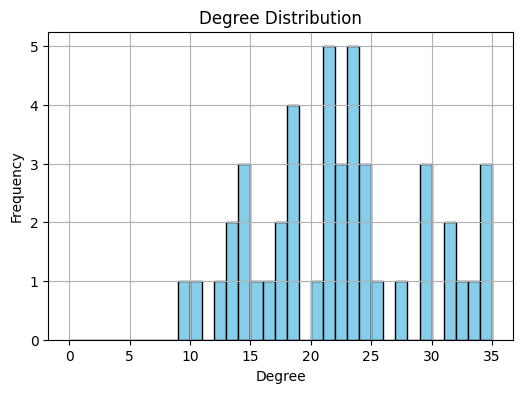


Average degree: 21.822222222222223


Step 4. Self-loop 존재 여부 확인
[X]


Step 5. 고립 노드 존재 여부 확인
# of isolated_nodes: 0개
index of isolated_nodes: []


Step 6. Visualization of Graph



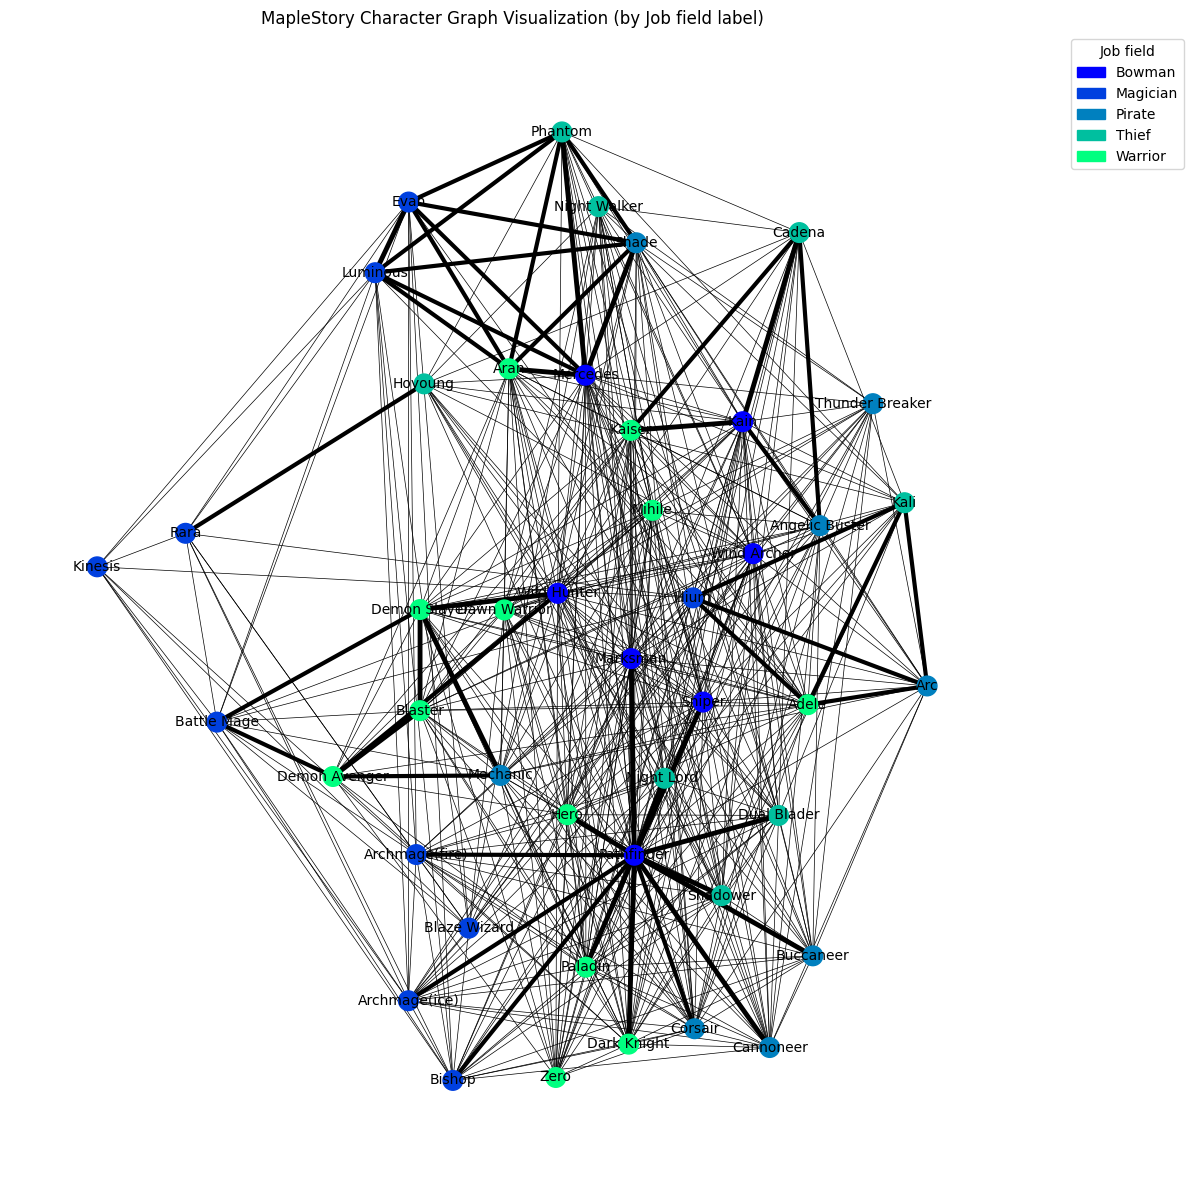

In [6]:
G = analyze_graph(data)
visualize_graph(G, data)

# **Graph Neural Networks**

# **Character 추천 시스템 완성(Using Link Prediction)**

In [7]:
import random

random.seed(42)
torch.manual_seed(42)

### Step 1. Edge Split (Train / Val / Test edge)
print('Step 1. Edge Split (Train / Val / Test edge)')
print()
unique_edges = edge_list[::2]  # 방향 하나만 추림
random.shuffle(unique_edges)

train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2
num_train = int(train_ratio * len(unique_edges))
num_val = int(val_ratio * len(unique_edges))
num_test = len(unique_edges) - num_train - num_val

train_edges = unique_edges[:num_train]
val_edges = unique_edges[num_train:num_train + num_val]
test_edges = unique_edges[num_train + num_val:]

def to_edge_index(edge_list):
    extended = edge_list + [(j, i) for (i, j) in edge_list]
    return torch.tensor(extended, dtype=torch.long).t().contiguous()

train_edge_index = to_edge_index(train_edges)
val_edge_index = to_edge_index(val_edges)
test_edge_index = to_edge_index(test_edges)

print(f'Train edge_index: {train_edge_index.shape}')
print(f'Validation edge_index: {val_edge_index.shape}')
print(f'Test edge_index: {test_edge_index.shape}')

Step 1. Edge Split (Train / Val / Test edge)

Train edge_index: torch.Size([2, 588])
Validation edge_index: torch.Size([2, 196])
Test edge_index: torch.Size([2, 198])


**util function for extract edge_weight**

In [8]:
def get_edge_weight_tensor(edge_index_tensor, full_edge_list, full_edge_weight_list):
    edge_index_list = [tuple(edge_index_tensor[:, i].tolist()) for i in range(edge_index_tensor.shape[1])]
    weight_lookup = {tuple(e): w for e, w in zip(full_edge_list, full_edge_weight_list)}
    return torch.tensor([weight_lookup.get((i, j), 0.0) for (i, j) in edge_index_list], dtype=torch.float)

**Hard + Random Negative Sampling**

In [9]:
import torch
import networkx as nx
import random

### Step 2. Mixed Negative Sampling
## distance-based negative edge + random negative edge
## 목적 : 실제로는 연결되어 있지 않지만, 연결될 법한 negative edge들을 섞어 학습효과를 높인다.
def mixed_negative_sampling(num_nodes, existing_edges_set, num_samples, G, dist_threshold=4, hard_ratio=0.5):

    hard_samples = []
    random_samples = []

    max_attempts = num_samples * 20
    attempts = 0

    while (len(hard_samples) + len(random_samples) < num_samples) and (attempts < max_attempts):
        i = torch.randint(0, num_nodes, (1,)).item()
        j = torch.randint(0, num_nodes, (1,)).item()

        if i == j:
            continue
        edge = (min(i, j), max(i, j))
        if edge in existing_edges_set:
            continue

        try:
            dist = nx.shortest_path_length(G, source=i, target=j)
        except nx.NetworkXNoPath:
            dist = float('inf')

        if dist >= dist_threshold and len(hard_samples) < int(num_samples * hard_ratio):
            hard_samples.append(edge)
            existing_edges_set.add(edge)
        elif len(random_samples) < int(num_samples * (1 - hard_ratio)):
            random_samples.append(edge)
            existing_edges_set.add(edge)

        attempts += 1

    ## hard + random
    all_samples = hard_samples + random_samples
    edge_index = torch.tensor(all_samples, dtype=torch.long).t().contiguous()  # shape : [2, N]
    return edge_index

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

### Step 3-1. Define GCN(Graph Conv Network)-based GNN Encoder
## 노드의 feature와 edge 연결 정보를 바탕으로 임베딩 z를 생성하는 Encoder 정의
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)

        return x

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Step 3-2. Link Predictor 정의
## 목적: GNN으로 생성된 노드 임베딩 쌍(z_i, z_j)을 받아 연결 가능성 score를 출력
class LinkPredictor(nn.Module):
    def __init__(self, method='dot'):

        super().__init__()
        self.method = method

    def forward(self, z, edge_index):

        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]

        if self.method == 'dot':
            score = (z_i * z_j).sum(dim=1)
        elif self.method == 'cosine':
            score = F.cosine_similarity(z_i, z_j)
        else:
            raise ValueError(f"Unknown similarity method: {self.method}")

        return score

# **Model Training**

**Loss function : Binary Classification (Link Prediction == Binary Classification Problem)**

In [12]:
criterion = torch.nn.BCEWithLogitsLoss()

**Function about 1 Epoch Train Step**

In [13]:
def train_step(model, predictor, data, edge_index, negative_edge_index, edge_weight, optimizer, criterion):
    model.train()
    predictor.train()
    optimizer.zero_grad()

    z = model(data.x, edge_index, edge_weight=edge_weight)
    pos_score = predictor(z, edge_index)
    pos_label = torch.ones(pos_score.size(0), device=z.device)

    neg_score = predictor(z, negative_edge_index)
    neg_label = torch.zeros(neg_score.size(0), device=z.device)

    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([pos_label, neg_label])

    loss = criterion(scores, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

**Function about Evaluation Step**

In [14]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def evaluate(model, predictor, data, edge_index, negative_edge_index, edge_weight):
    model.eval()
    predictor.eval()

    z = model(data.x, edge_index, edge_weight=edge_weight)

    ## Positive scores
    pos_score = predictor(z, edge_index)
    pos_label = torch.ones(pos_score.size(0), device=z.device)

    ## Negative scores
    neg_score = predictor(z, negative_edge_index)
    neg_label = torch.zeros(neg_score.size(0), device=z.device)

    ## Concatenate
    scores = torch.cat([pos_score, neg_score], dim=0).cpu()
    labels = torch.cat([pos_label, neg_label], dim=0).cpu()

    ## Convert logits to probability
    probs = torch.sigmoid(scores)

    ## ROC-AUC 계산
    roc_auc = roc_auc_score(labels.numpy(), probs.numpy())

    preds = probs > 0.5
    acc = (preds == labels).float().mean().item()

    return acc, roc_auc

**Function about Training Loop**

In [15]:
def train_model(data, x, train_edge_index, val_edge_index,
                edge_list, edge_weight_list, num_epochs=100):

    encoder = GCNEncoder(in_channels=x.shape[1], hidden_channels=64, out_channels=32)
    predictor = LinkPredictor(method='dot')
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(predictor.parameters()), lr=1e-3)
    criterion = torch.nn.BCEWithLogitsLoss()

    ## Train/Val edge_weight 추출
    train_edge_weight = get_edge_weight_tensor(train_edge_index, edge_list, edge_weight_list)
    val_edge_weight = get_edge_weight_tensor(val_edge_index, edge_list, edge_weight_list)

    ## train_edges 정의
    train_edges = [tuple(train_edge_index[:, i].tolist()) for i in range(train_edge_index.shape[1])]
    G_train = to_networkx(Data(edge_index=train_edge_index), to_undirected=True)

    for epoch in range(1, num_epochs + 1):
        ## Negative edge 매 epoch마다 샘플링
        neg_edge_index = mixed_negative_sampling(
            num_nodes=x.shape[0],
            existing_edges_set=set(train_edges),
            num_samples=train_edge_index.shape[1] // 2,
            G=G_train
        )
        neg_edge_index = torch.cat([neg_edge_index, neg_edge_index[[1, 0]]], dim=1)

        ## Train step
        loss = train_step(encoder, predictor, data,
                          train_edge_index, neg_edge_index,
                          edge_weight=train_edge_weight,
                          optimizer=optimizer, criterion=criterion)

        ## Evaluate
        if epoch % 10 == 0:
            val_acc, val_auc = evaluate(encoder, predictor, data,
                               val_edge_index, neg_edge_index,
                               edge_weight=val_edge_weight)
            print(f"[Epoch {epoch}] Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Val ROC-AUC: {val_auc:.4f}")

    return encoder, predictor

**Training**

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GCNEncoder(in_channels=x.shape[1], hidden_channels=64, out_channels=32).to(device)
predictor = LinkPredictor(method='dot').to(device)
train_edge_weight = get_edge_weight_tensor(train_edge_index, edge_list, edge_weight_list)
val_edge_weight   = get_edge_weight_tensor(val_edge_index, edge_list, edge_weight_list)

data = data.to(device)
x = data.x.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)
train_edge_weight = train_edge_weight.to(device)
val_edge_weight = val_edge_weight.to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(predictor.parameters()), lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()

In [17]:
G_train = to_networkx(Data(edge_index=train_edge_index), to_undirected=True)

/usr/local/lib/python3.12/dist-packages/torch_geometric/data/data.py:228: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  offset = offset + store.num_nodes
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/convert.py:160: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  assert node_store.num_nodes is not None
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/convert.py:161: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  for i in range(node_store.num_nodes):


In [18]:
encoder, predictor = train_model(
    data=data,
    x=x,
    train_edge_index=train_edge_index,
    val_edge_index=val_edge_index,
    edge_list=edge_list,  # list of (i, j)
    edge_weight_list=edge_weight_list,  # list of float
    num_epochs=700
)

[Epoch 10] Loss: 0.6181 | Val Acc: 0.4000 | Val ROC-AUC: 0.7354
[Epoch 20] Loss: 0.6116 | Val Acc: 0.4000 | Val ROC-AUC: 0.6902
[Epoch 30] Loss: 0.6017 | Val Acc: 0.4694 | Val ROC-AUC: 0.7240
[Epoch 40] Loss: 0.5949 | Val Acc: 0.5224 | Val ROC-AUC: 0.7156
[Epoch 50] Loss: 0.5788 | Val Acc: 0.5796 | Val ROC-AUC: 0.7419
[Epoch 60] Loss: 0.5659 | Val Acc: 0.5796 | Val ROC-AUC: 0.7759
[Epoch 70] Loss: 0.5467 | Val Acc: 0.6286 | Val ROC-AUC: 0.7960
[Epoch 80] Loss: 0.5288 | Val Acc: 0.6449 | Val ROC-AUC: 0.7954
[Epoch 90] Loss: 0.5227 | Val Acc: 0.6571 | Val ROC-AUC: 0.8202
[Epoch 100] Loss: 0.5223 | Val Acc: 0.6408 | Val ROC-AUC: 0.7997
[Epoch 110] Loss: 0.5202 | Val Acc: 0.6367 | Val ROC-AUC: 0.8222
[Epoch 120] Loss: 0.4840 | Val Acc: 0.6612 | Val ROC-AUC: 0.8079
[Epoch 130] Loss: 0.4847 | Val Acc: 0.6776 | Val ROC-AUC: 0.8151
[Epoch 140] Loss: 0.5020 | Val Acc: 0.6816 | Val ROC-AUC: 0.8167
[Epoch 150] Loss: 0.4838 | Val Acc: 0.6939 | Val ROC-AUC: 0.8336
[Epoch 160] Loss: 0.4719 | Val Acc

In [19]:
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'predictor_state_dict': predictor.state_dict(),
}, 'trained_model.pth')

# **Experiment**

In [20]:
import torch
import torch.nn.functional as F

def recommend_from_embeddings(z, character_names, edge_index, predictor,
                              top_percent_range=(0.05, 0.1), method='cosine'):

    z = F.normalize(z, p=2, dim=1)

    num_nodes = z.shape[0]
    recommendations = {}

    for i in range(num_nodes):
        candidates = [(i, j) for j in range(num_nodes) if i != j]
        edge_idx = torch.tensor(candidates, dtype=torch.long).t().contiguous()

        with torch.no_grad():
            scores = predictor(z, edge_idx)
            scores = torch.sigmoid(scores)  # [0, 1]

        ## 점수 기준 상위 percentile 정렬
        sorted_scores, indices = torch.sort(scores, descending=True)

        lower_k = int(len(sorted_scores) * top_percent_range[0])
        upper_k = int(len(sorted_scores) * top_percent_range[1])
        selected_range = sorted_scores[lower_k:upper_k]
        selected_indices = indices[lower_k:upper_k]


        recommended = []
        for rank, idx in enumerate(selected_indices):
            target_node = candidates[idx.item()][1]
            target_name = character_names[target_node]
            score = scores[idx].item()
            recommended.append((target_name, score))

        recommendations[character_names[i]] = recommended

    return recommendations


In [21]:
## character list 준비
character_list = data_frame['Character'].tolist()

## trained embedding 생성
with torch.no_grad():
    encoder.eval()
    z = encoder(data.x, train_edge_index, edge_weight=train_edge_weight)

In [22]:
recs = recommend_from_embeddings(
    z=z,
    character_names=character_list,
    edge_index=train_edge_index,
    predictor=predictor,
    top_percent_range=(0.03, 0.07),  # 상위 3 ~ 7%만 추천
    method='cosine'
)

for name, top_list in recs.items():
    print(f"'{name}' 유저에게 추천되는 직업:")
    for i, (rname, score) in enumerate(top_list):
        print(f"  - Top-{i+1}: {rname} (score: {score:.4f})")
    print()

'Hero' 유저에게 추천되는 직업:
  - Top-1: Paladin (score: 0.7228)
  - Top-2: Corsair (score: 0.7194)

'Paladin' 유저에게 추천되는 직업:
  - Top-1: Zero (score: 0.7208)
  - Top-2: Corsair (score: 0.7201)

'Dark Knight' 유저에게 추천되는 직업:
  - Top-1: Paladin (score: 0.7050)
  - Top-2: Corsair (score: 0.7008)

'Dawn Warrior' 유저에게 추천되는 직업:
  - Top-1: Zero (score: 0.7111)
  - Top-2: Blaster (score: 0.7099)

'Mihile' 유저에게 추천되는 직업:
  - Top-1: Hero (score: 0.7149)
  - Top-2: Wind Archer (score: 0.7147)

'Blaster' 유저에게 추천되는 직업:
  - Top-1: Hero (score: 0.7188)
  - Top-2: Paladin (score: 0.7102)

'Demon Slayer' 유저에게 추천되는 직업:
  - Top-1: Demon Avenger (score: 0.7182)
  - Top-2: Battle Mage (score: 0.6936)

'Demon Avenger' 유저에게 추천되는 직업:
  - Top-1: Demon Slayer (score: 0.7182)
  - Top-2: Battle Mage (score: 0.7128)

'Aran' 유저에게 추천되는 직업:
  - Top-1: Phantom (score: 0.7141)
  - Top-2: Mercedes (score: 0.7058)

'Kaiser' 유저에게 추천되는 직업:
  - Top-1: Blaster (score: 0.7047)
  - Top-2: Mihile (score: 0.6966)

'Adele' 유저에게 추천되는 직업:
  - T

# **Visualize and Analysis Result**

**Using T-SNE**

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_embedding_tsne(z, data_frame):
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    z_2d = tsne.fit_transform(z.cpu().numpy())

    job_fields = data_frame["Job Field"]
    job_names = data_frame["Character"].tolist()

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1],
                    hue=job_fields,
                    palette="winter",
                    s=100, alpha=0.85, edgecolor='gray')

    for i, name in enumerate(job_names):
        plt.text(z_2d[i, 0]+0.2, z_2d[i, 1], name, fontsize=7)

    plt.title("T-SNE of Node Embeddings (Colored by Job Field)", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

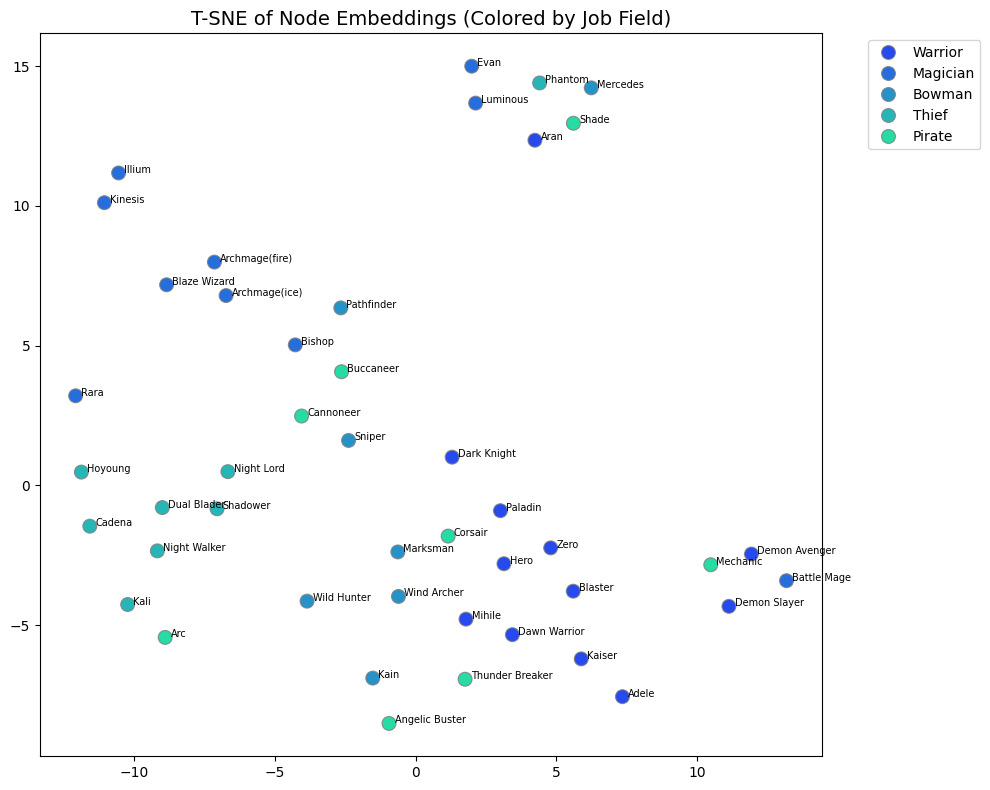

In [24]:
visualize_embedding_tsne(z, data_frame)

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_embedding_tsne(z, data_frame):
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    z_2d = tsne.fit_transform(z.cpu().numpy())

    kind = data_frame["Kind"]
    job_names = data_frame["Character"].tolist()

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1],
                    hue=kind,
                    palette="Paired",
                    s=100, alpha=0.85, edgecolor='gray')

    for i, name in enumerate(job_names):
        plt.text(z_2d[i, 0]+0.2, z_2d[i, 1], name, fontsize=7)

    plt.title("T-SNE of Node Embeddings (Colored by Kind)", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

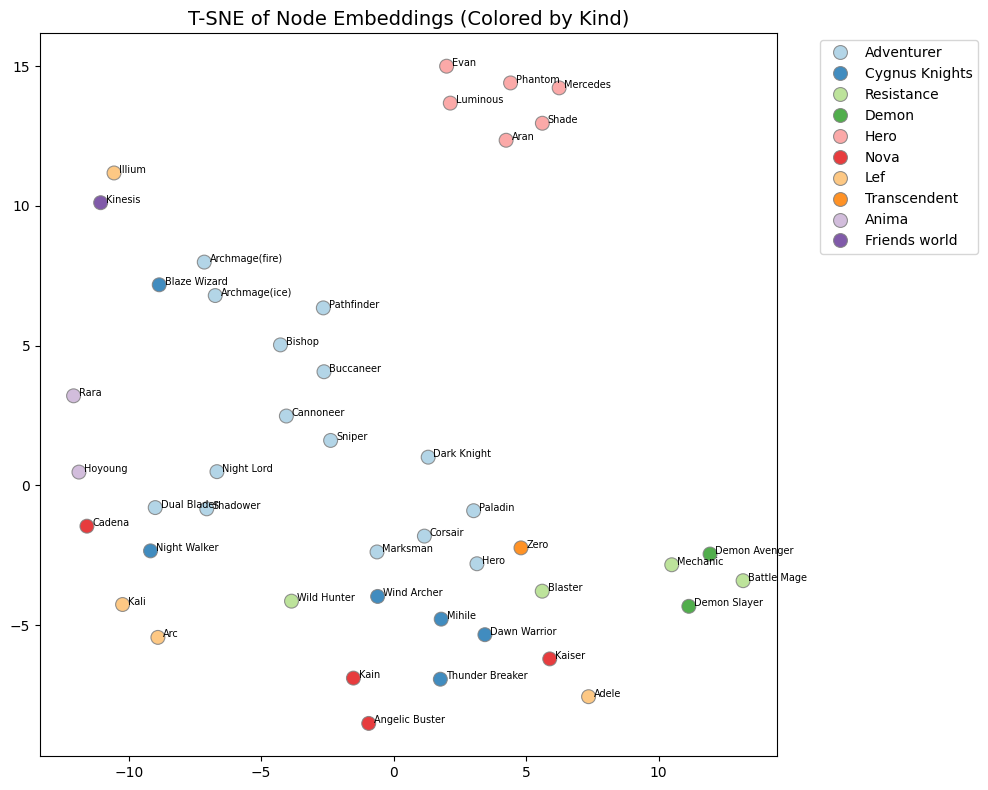

In [26]:
visualize_embedding_tsne(z, data_frame)

In [27]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_tsne_kmeans(z, data_frame, num_clusters=5):
    ## T-SNE 변환
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    z_2d = tsne.fit_transform(z.cpu().numpy())

    ## K-Means 군집화
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(z_2d)

    ## 시각화용 데이터프레임
    tsne_df = pd.DataFrame({
        'x': z_2d[:, 0],
        'y': z_2d[:, 1],
        'Character': data_frame["Character"],
        'Job Field': data_frame["Job Field"],
        'Cluster': cluster_labels
    })

    ## 시각화
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=tsne_df, x='x', y='y', hue='Cluster', palette='Set2', s=100, edgecolor='gray')

    for i in range(len(tsne_df)):
        plt.text(tsne_df.loc[i, 'x'] + 0.2, tsne_df.loc[i, 'y'],
                 tsne_df.loc[i, 'Character'], fontsize=7)

    plt.title(f"T-SNE with K-Means Clustering (k={num_clusters})", fontsize=14)
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


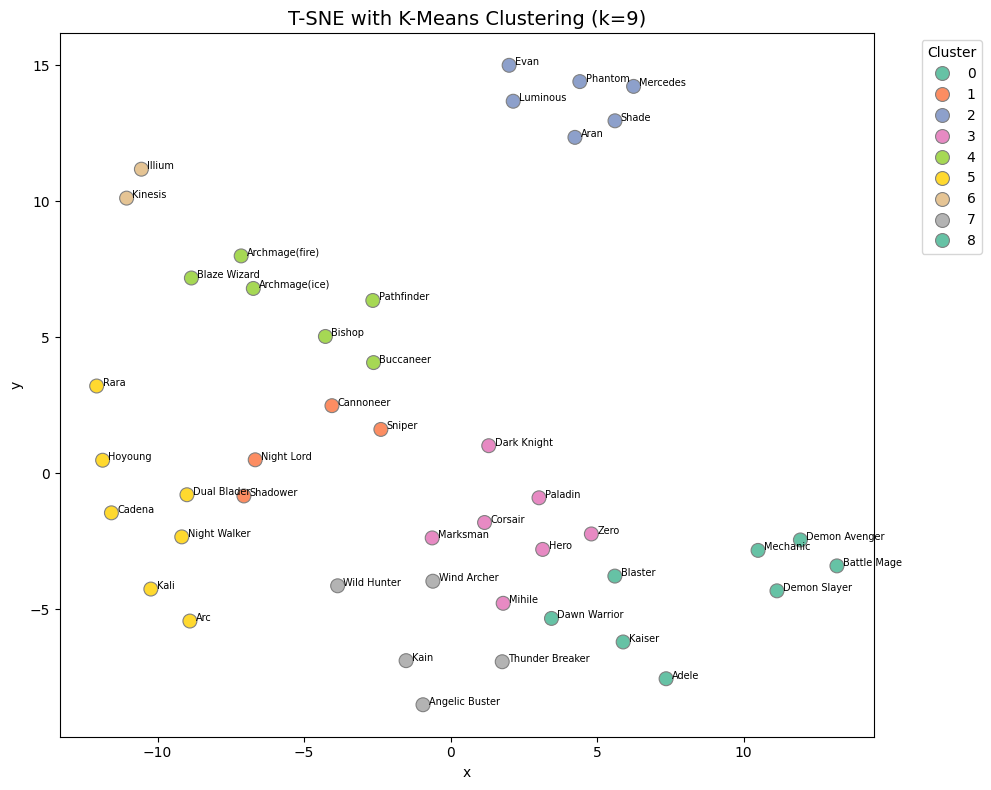

In [28]:
visualize_tsne_kmeans(z, data_frame, num_clusters=9)